In [1]:
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon

In [2]:
p = 0.84
k = 2.15
gamma = 1.42

In [3]:
home_pdf = pd.read_pickle('../../data/derived/before/home_pdf.pkl')
sequence_length = np.load('../../data/derived/before/sequence_length.npy', allow_pickle=True)

In [4]:
grid_to_hotspot_level = pd.read_pickle('../../data/derived/before/hotspot_level_by_grid.pkl')
hotspot_level_to_grid = defaultdict(list)
for k_, v_ in grid_to_hotspot_level.items():
    hotspot_level_to_grid[v_].append(k_)

In [5]:
homes = list(home_pdf.keys())
homes_p = [home_pdf[home] for home in homes]

In [6]:
d = pd.read_pickle('../../data/derived/before/distance.pkl')

In [7]:
from collections import Counter, defaultdict

import numpy as np
from scipy.stats import entropy

def generate_sequence(
    p, gamma, k, generated_homes, sequence_length, hotspot_level_to_grid, d,
):
    distribution = np.array([1 / np.power(i + 1, k) for i in range(10)])
    distribution /= sum(distribution)

    generated_sequences = []
    for home, length in zip(generated_homes, sequence_length):
        next_grids = [home]
        for i in range(length - 1):
            if np.random.random() < 1 - np.power(p,1 + i):
                next_grid = np.random.choice(next_grids)
            else:
                level = np.random.choice(np.arange(10), p=distribution) + 1
                c = Counter(next_grids)
                m = max(c.values())
                home = np.random.choice([key for key in c if c[key] == m])
                next_grid = get_next_grid(home, gamma, d, hotspot_level_to_grid[level])
            next_grids.append(next_grid)
        generated_sequences.append(next_grids)

    return generated_sequences

def get_next_grid(home, gamma, d, target_grids):
    target_grids = [spot for spot in target_grids if spot != home]
    weight = np.array([1 / np.power(d[home][spot], gamma) for spot in target_grids])
    weight = weight / sum(weight)

    return target_grids[np.random.choice(np.arange(len(target_grids)), p=weight)]

In [8]:
generated_homes_idx = np.random.choice(
        np.arange(len(homes)), size=len(sequence_length), replace=True, p=homes_p
)

In [9]:
generated_homes = [homes[idx] for idx in generated_homes_idx]

In [10]:
generated_sequences =  generate_sequence(
        p, gamma, k, generated_homes, sequence_length, hotspot_level_to_grid, d,
)

In [23]:
from collections import Counter, defaultdict

home_list = []
ratio_list = []
for row in generated_sequences:
    counter_dict = dict(Counter(row))
    max_val = max(counter_dict.values())
    max_keys = [k for k, v in counter_dict.items() if v == max_val]
    home = max_keys[np.random.choice(len(max_keys))]
    home_list.append(home)
    ratio_list.append(max_val/len(row))


In [24]:
length_list = np.array(list(map(len, generated_sequences)))

In [25]:
ratio_list = np.array(ratio_list)

In [16]:
sequences = np.load('../../data/derived/before/sequence.npy', allow_pickle=True)
vendor_to_grid = pd.read_pickle('../../data/derived/before/vendor_to_grid.pkl')
sequences = np.array([list(map(vendor_to_grid.get, row)) for row in sequences])

/home/balla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
from collections import Counter, defaultdict
length_list_data = []
ratio_list_data = []
for row in sequences:
    counter_dict = dict(Counter(row))
    max_val = max(counter_dict.values())
    max_keys = [k for k, v in counter_dict.items() if v == max_val]
    home = max_keys[np.random.choice(len(max_keys))]
    ratio_list_data.append(max_val/len(row))
    length_list_data.append(len(row))


In [20]:
len(ratio_list_data,)

202525

In [21]:
len(length_list_data)

202525

In [14]:
from matplotlib import cm, figure, font_manager

INPUT_FONT_FILE = '../../assets/Helvetica.ttf'
prop = font_manager.FontProperties(fname=INPUT_FONT_FILE, size=22)
small_prop = font_manager.FontProperties(fname=INPUT_FONT_FILE, size=18)

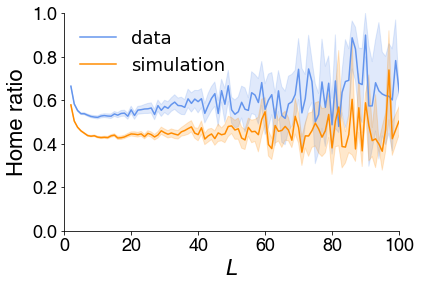

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.DataFrame({
    'ratio': ratio_list,
    'length': length_list
})
df_ = pd.DataFrame({
    'ratio': ratio_list_data,
    'length': length_list_data
})
ax = sns.lineplot(x="length", y="ratio",
             data=df_,  color='cornflowerblue', label='data')
ax = sns.lineplot(x="length", y="ratio",
             data=df, label='simulation', color='darkorange',)
for label in ax.get_yticklabels():
    label.set_fontproperties(small_prop)
for label in ax.get_xticklabels():
     label.set_fontproperties(small_prop)
ax.set_xlabel(r'$L$', fontproperties=prop)
ax.set_ylabel('Home ratio',fontproperties=prop)
ax.set_xlim([0,100])
ax.set_ylim([0,1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(fontsize=18, frameon=False)
plt.savefig('figs/home_ratio_best.pdf', bbox_inches='tight')